## Import Libraries and Load Data

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
warnings.simplefilter("ignore")
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

In [4]:
# Merge the given 2 datasets into fullData

# data1 = pd.read_csv('costello_ace_2017-2018.csv')
# data2 = pd.read_csv('costello_ace_2015-2016.csv')
# merged_data = pd.concat([data1,data2])
# merged_data.to_csv('full_data.csv')

fullData = pd.read_csv('full_data.csv')

In [5]:
fullData['Department Name'].value_counts().head(20)

PAINT & PAINT SUPPLIES              4260394
LAWN, GARDEN & FARM SUPPLIES        3659708
HARDWARE                            2685520
FASTENERS                           2483960
PLUMBING SUPPLIES & FIXTURES        2297175
FLASHLIGHTS, LIGHTING & SUPPLIES    2037099
NOTIONS & MISCELLANEOUS             1790262
HOUSEWARES & GIFTS                  1751216
ELECTRICAL SUPPLIES                 1564721
CLEANING SUPPLIES                   1544942
HAND TOOLS & TOOL ACCESSORIES       1442435
ACE REWARDS INSTANT SAVINGS         1052216
SPORTING GOODS                       950873
IN STORE COUPONS                     935441
AUTOMOTIVE                           659946
DONTATIONS                           653816
OUTDOOR LIVING & FURNITURE           606121
HEATING & COOLING SUPPLIES           550702
OUTDOOR EQUIPMENT & POWER TOOLS      441175
STATIONARY & STORE SUPPLIES          236320
Name: Department Name, dtype: int64

## Time Series Analysis

### FILTER Particular Department Data

In [148]:
temp = fullData.loc[fullData['Department Name'] == 'AUTOMOTIVE'] #A OUTDOOR EQUIPMENT & POWER TOOLS
filtered_dept_data = temp[(temp['Line Item Transaction Type']=='Sale')]
filtered_dept_data.shape
filtered_dept_data.isnull().sum()

Unnamed: 0                         0
Date                               0
Transaction Time                   0
Customer Number                    1
Receipt Number                     0
Store #                            0
Store Name                         0
Scanned UPC                     2723
Item Number                        0
Item Description                   0
Net Sales Units                    0
Net Sales                          0
Cost                               0
Gross Margin                       0
Gross Margin %                   456
Department Code                    0
Department Name                    0
Class Code                         9
Class Name                         0
Fineline Code                    178
Fineline Name                      0
Item was Scanned                  17
MIP Promo ID                  502438
Promo/Discount                497483
Dynamic Promo ID                   0
Actual Price                       0
Retail Price                       0
A

In [149]:
# Drop irrelevant columns. Keep Only Date, Department Name and Net Sales Unit
cols = [ 'Transaction Time',
 'Customer Number',
 'Receipt Number',
 'Store #',
 'Store Name',
 'Scanned UPC',
 'Item Number',
 'Item Description',
 #'Department Name',
 'Net Sales',
 'Cost',
 'Gross Margin',
 'Gross Margin %',
 'Department Code',
 'Class Code',
 'Class Name',
 'Fineline Code',
 'Fineline Name',
 'Item was Scanned',
 'MIP Promo ID',
 'Promo/Discount',
 'Dynamic Promo ID',
 'Actual Price',
 'Retail Price',
 'Actual-Retail',
 'Taxable',
 'Tender Type',
 '$ Off Retail',
 'Zip Code',
 'Zip Plus-4',
 'Loyalty ID',
 'Clerk',
 'Item Type',
 'Line #',
 'Line Item Transaction Type',
 'Pricing Source',
 'Return Code']
filtered_dept_data.drop(cols, axis=1, inplace=True)

### Data Cleaning

In [150]:
filtered_dept_data = filtered_dept_data.sort_values('Date')

In [151]:
filtered_dept_data['Net Sales Units']=filtered_dept_data['Net Sales Units'].str.replace(',','')
filtered_dept_data['Net Sales Units']=pd.to_numeric(filtered_dept_data['Net Sales Units'])

In [152]:
filtered_dept_data['Date']= pd.to_datetime(filtered_dept_data['Date'])

In [153]:
filtered_dept_data_group = filtered_dept_data.groupby('Date')['Net Sales Units'].sum().reset_index()
filtered_dept_data_group = filtered_dept_data_group.set_index('Date')

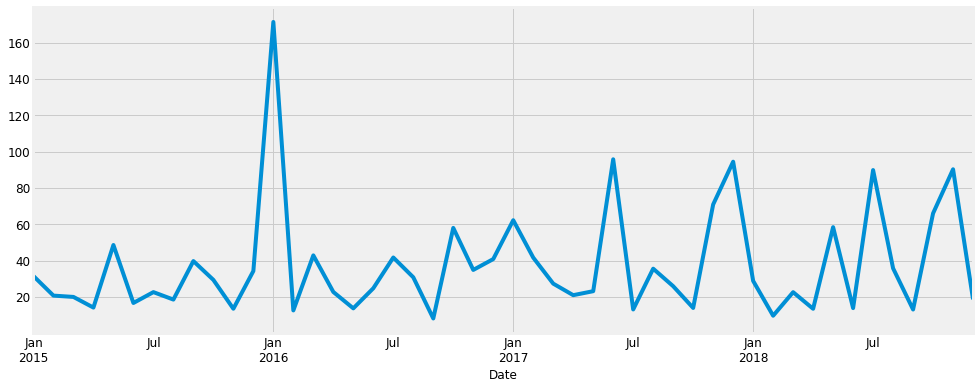

In [154]:
y = filtered_dept_data_group['Net Sales Units'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

### Log Transformation and Time Lag Shifting

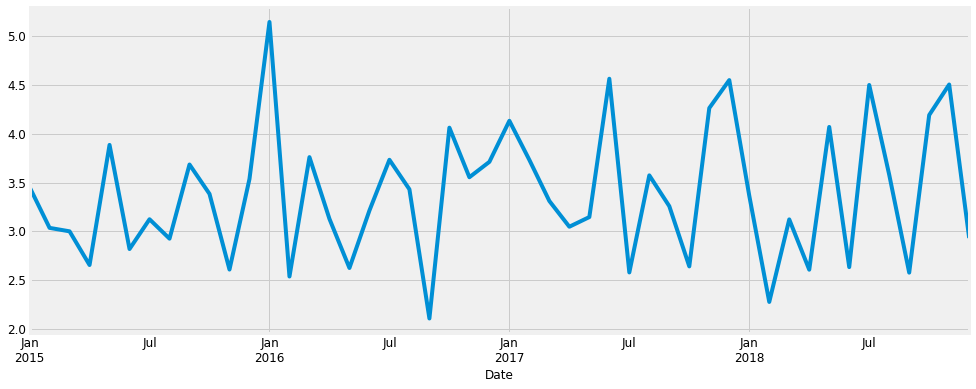

In [155]:
log_transformed_data = np.log(y)
log_transformed_data.plot(figsize=(15, 6))
plt.show()

In [156]:
seasonally_diffed_data = log_transformed_data.diff(1)[1:]
y = seasonally_diffed_data

In [157]:
y

Date
2015-02-01   -0.417583
2015-03-01   -0.035423
2015-04-01   -0.344973
2015-05-01    1.229827
2015-06-01   -1.066021
2015-07-01    0.304818
2015-08-01   -0.198624
2015-09-01    0.759176
2015-10-01   -0.300919
2015-11-01   -0.774788
2015-12-01    0.928032
2016-01-01    1.607402
2016-02-01   -2.606423
2016-03-01    1.222384
2016-04-01   -0.632228
2016-05-01   -0.503085
2016-06-01    0.588392
2016-07-01    0.519522
2016-08-01   -0.302190
2016-09-01   -1.322670
2016-10-01    1.953919
2016-11-01   -0.507748
2016-12-01    0.157582
2017-01-01    0.420379
2017-02-01   -0.400624
2017-03-01   -0.420450
2017-04-01   -0.263557
2017-05-01    0.098960
2017-06-01    1.416324
2017-07-01   -1.983248
2017-08-01    0.993885
2017-09-01   -0.315517
2017-10-01   -0.616738
2017-11-01    1.621321
2017-12-01    0.286449
2018-01-01   -1.184060
2018-02-01   -1.087801
2018-03-01    0.845524
2018-04-01   -0.515175
2018-05-01    1.461687
2018-06-01   -1.435018
2018-07-01    1.864809
2018-08-01   -0.919164
2018-0

### Stationary Check for model fitting

In [158]:
from statsmodels.tsa.stattools import adfuller
#def test_stationarity(data):
p_val=adfuller(y)[1]
if p_val >= 0.05:
    print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
else:
    print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))
#test_stationarity(original_data) 

Time series data is stationary. Adfuller test pvalue=0.0010717653398310974


### Arima

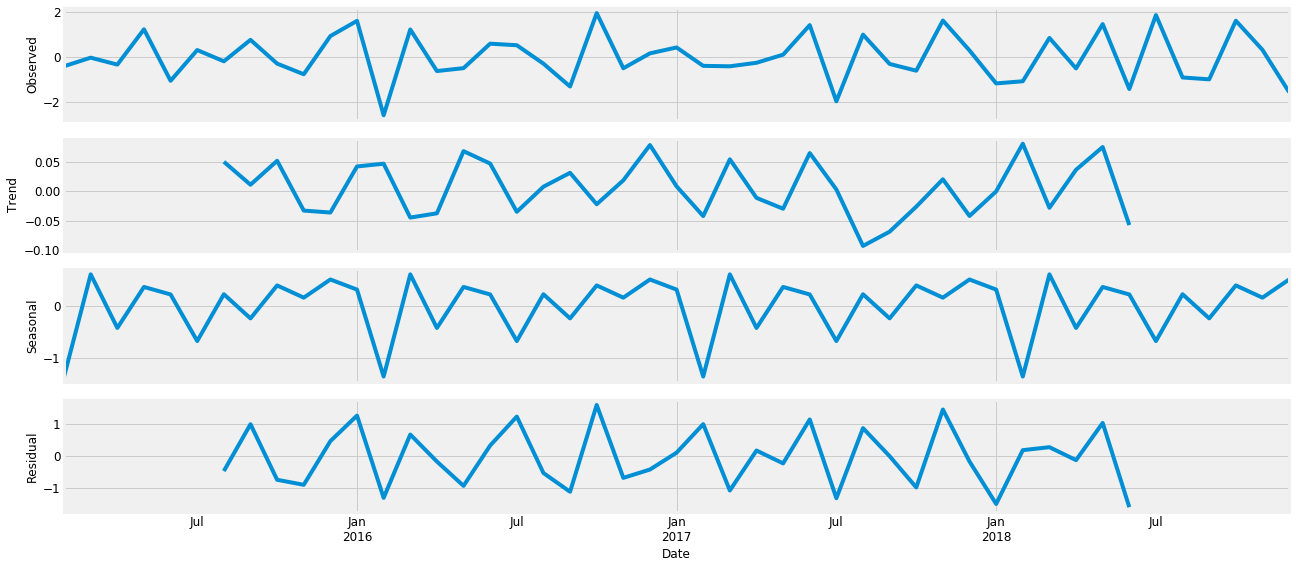

In [159]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [160]:
## Time series forecasting with SARIMA & ARIMA

# p: Trend autoregression order.
# d: Trend difference order.
# q: Trend moving average order.
# Seasonal Elements
# There are four seasonal elements that are not part of ARIMA that must be configured; they are:

# P: Seasonal autoregressive order.
# D: Seasonal difference order.
# Q: Seasonal moving average order.
# m: The number of time steps for a single seasonal period.

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, (results.aic)))
        except:
            continue
            
# Together, the notation for an SARIMA model is specified as:
# SARIMA(p,d,q)(P,D,Q)m
# 1
# SARIMA(p,d,q)(P,D,Q)m
# Where the specifically chosen hyperparameters for a model are specified; for example:

# SARIMA(3,1,0)(1,1,0)12
# 1
# SARIMA(3,1,0)(1,1,0)12
# Importantly, the m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle.

#cylinder
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:242.05107407376676

#Bird Seed
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:215.48938602340846
# The Root Mean Squared Error of our forecasts is 25.03
# The Mean Squared Error of our forecasts is 626.46

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:138.25520942117382
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1371.3903699508132
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:132.18261312058496
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:109.79636058935951
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1354.945590083873
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:83.53000971153187
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:102.93990019598097
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1412.5039554347698
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:102.04325372028181
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:88.017904395068
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1454.2326810568177
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:66.95964799876973
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:185.08884721022164
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1348.5376551860054
ARIMA(0, 1, 0)x(0, 1, 0, 

In [161]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 0, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


# ### Diagnostics

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3386      0.214     -1.581      0.114      -0.759       0.081
ma.L1         -1.0000   1415.001     -0.001      0.999   -2774.352    2772.352
ar.S.L12      -0.6672      0.239     -2.787      0.005      -1.136      -0.198
sigma2         0.6596    933.372      0.001      0.999   -1828.717    1830.036


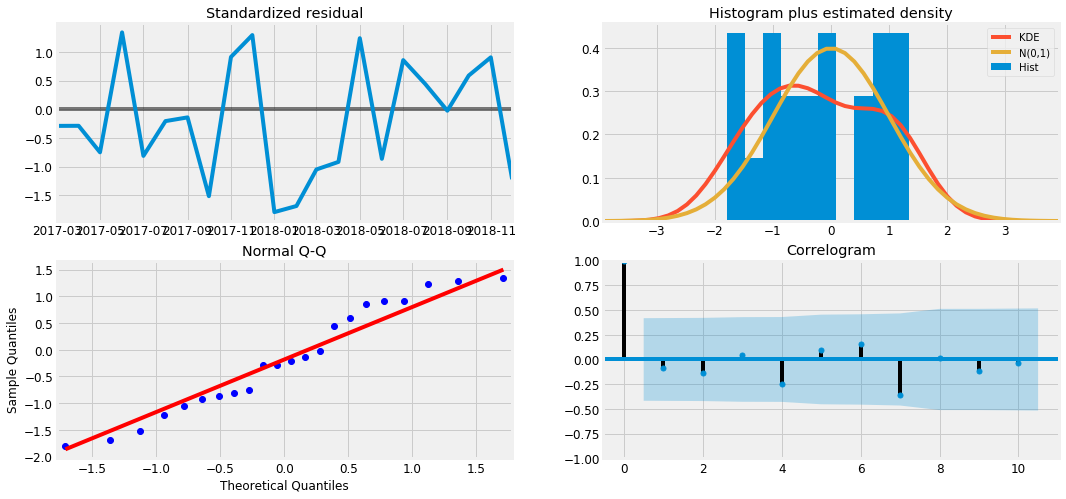

In [162]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Prediction

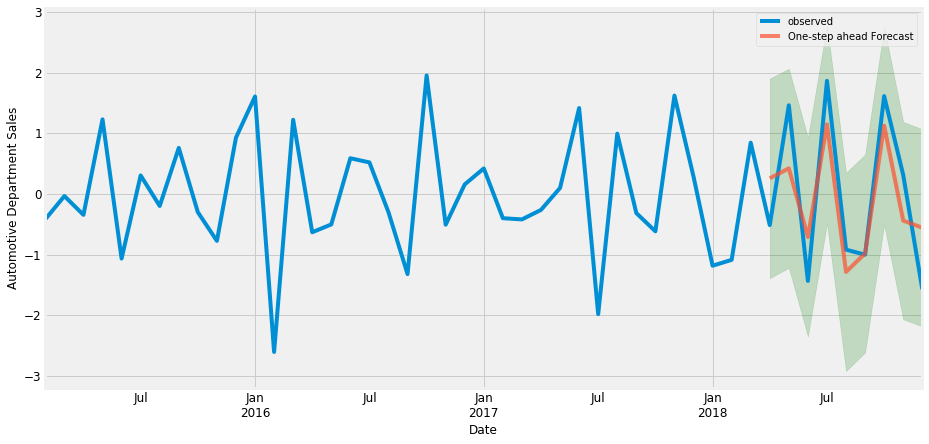

In [168]:
pred = results.get_prediction(start=pd.to_datetime('2018-04-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Automotive Department Sales')
plt.legend()
plt.show()

In [164]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.52


In [169]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.72


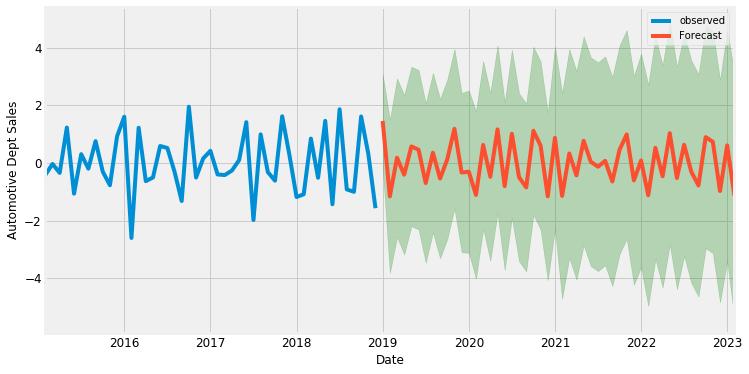

In [167]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(11, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Automotive Dept Sales')
plt.legend()
plt.show()